Copyright 2023 IBM Inc. All rights reserved  
SPDX-License-Identifier: Apache-2.0

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (25, 10)
import rkhsid as RKHS

# Function Estimation -- Simple univariate function
The `FunctionEstimator` class can be used to estimate functions with with arbitrary domain and range $f: R^m \rightarrow R^n$. Here's the estimation of a scalar function $f(x)$ of a single variable.

### Generate some data

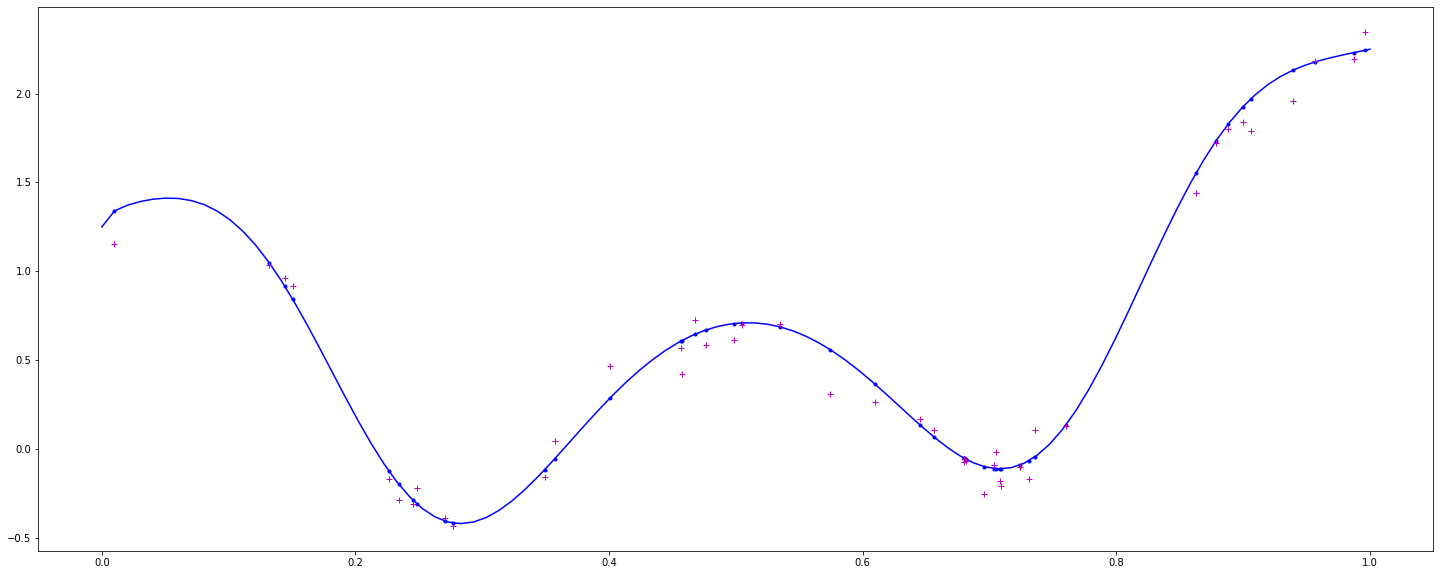

In [2]:
xax = np.linspace(0, 1, num=100)
func1 = (
    lambda x: (x - 0.5) ** 2 + np.cos(np.pi * x**2 * (x - 1) ** 2 * 24) + np.sqrt(x)
)
# Observations
N_obsv = 45
x_obsv = np.random.rand(N_obsv, 1)
# NOTE: it is important that x_obsv has 2 dims, even if the last one is singleton
y_obsv = func1(x_obsv)
y_noisy_obsv = y_obsv + np.random.randn(N_obsv, 1) / 10
plt.plot(xax, func1(xax), "b")
plt.plot(x_obsv, y_obsv, "b.")
plt.plot(x_obsv, y_noisy_obsv, "m+", label="Noisy measurements")
# plt.gcf().set_size_inches((8,6))

### Create the `FunctionEstimator` object and fit

In [3]:
# The bias space and the kernel of the RKHS need to be defined
bias_eval = RKHS.linear_const_eval  # Bias space with constant and linear term
sine_kernel = RKHS.SinKernel(max_freq=40)  #  default Sine Kernel

# Create the Estimator
funcest = RKHS.FunctionEstimator(
    bias_func_eval=bias_eval, kernel_func_eval=sine_kernel.eval
)

# And fit it, using the data
funcest.fit(
    x_obsv,
    y_noisy_obsv,
    data_cost_weight=1000 / N_obsv,
    rkhs_weight=1e-6,
    bias_weight=0,
)
# try rkhs_weight=1e-6 for some clear overfitting artefacts

### Evaluate the estimate

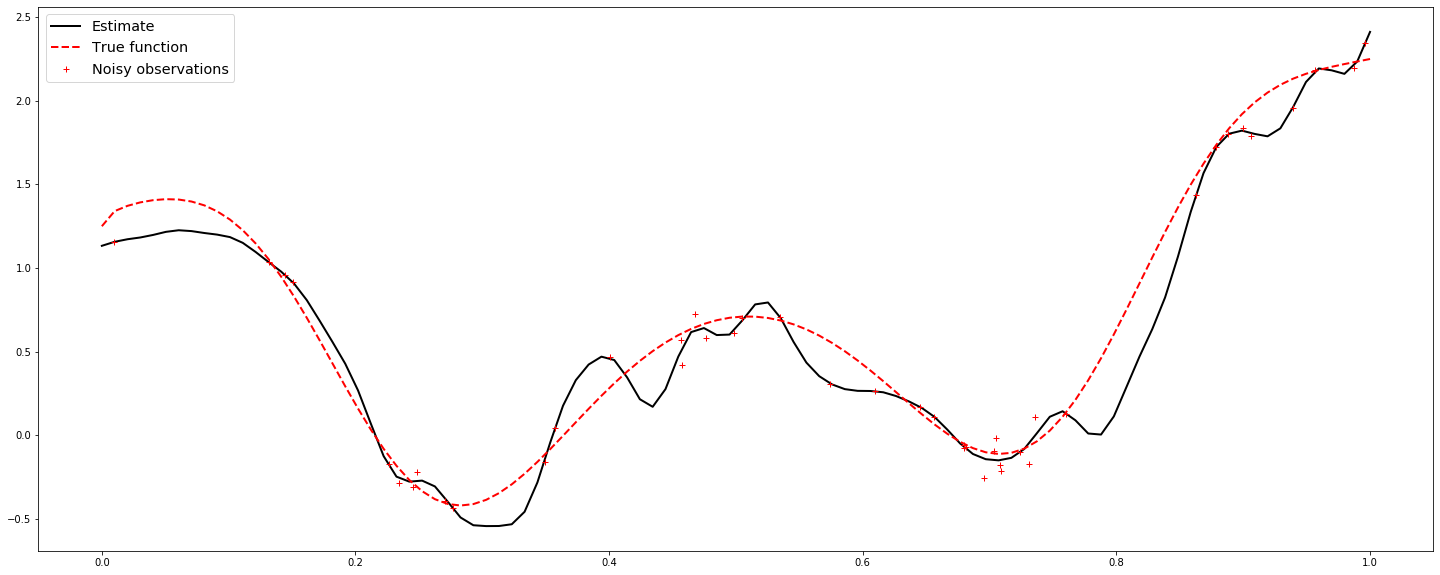

In [4]:
# Estimator object allows evaluating estimate
y_est = funcest.eval(xax[:, np.newaxis])
# Plotting code
plt.plot(xax, y_est, "k", label="Estimate", lw=2)
plt.plot(xax, func1(xax), "r--", label="True function", lw=2)
plt.plot(x_obsv, y_noisy_obsv, "r+", label="Noisy observations")
plt.legend(fontsize="x-large")

# System Identification -- Simple nonlinear system

The `DynamicalSystemEstimator` class can be used to identify systems with arbitrary input and output dimensions, from known inputs and measurements of the outputs.  
We're doing a scalar system with exogenous input, i.e. 
$$y[t+1] = -y[t]/2 + \sin(20 y^2[t])/10 + (\sin(u[t]) + u[t])$$

Text(0.5, 1.0, 'Input_trajectories')

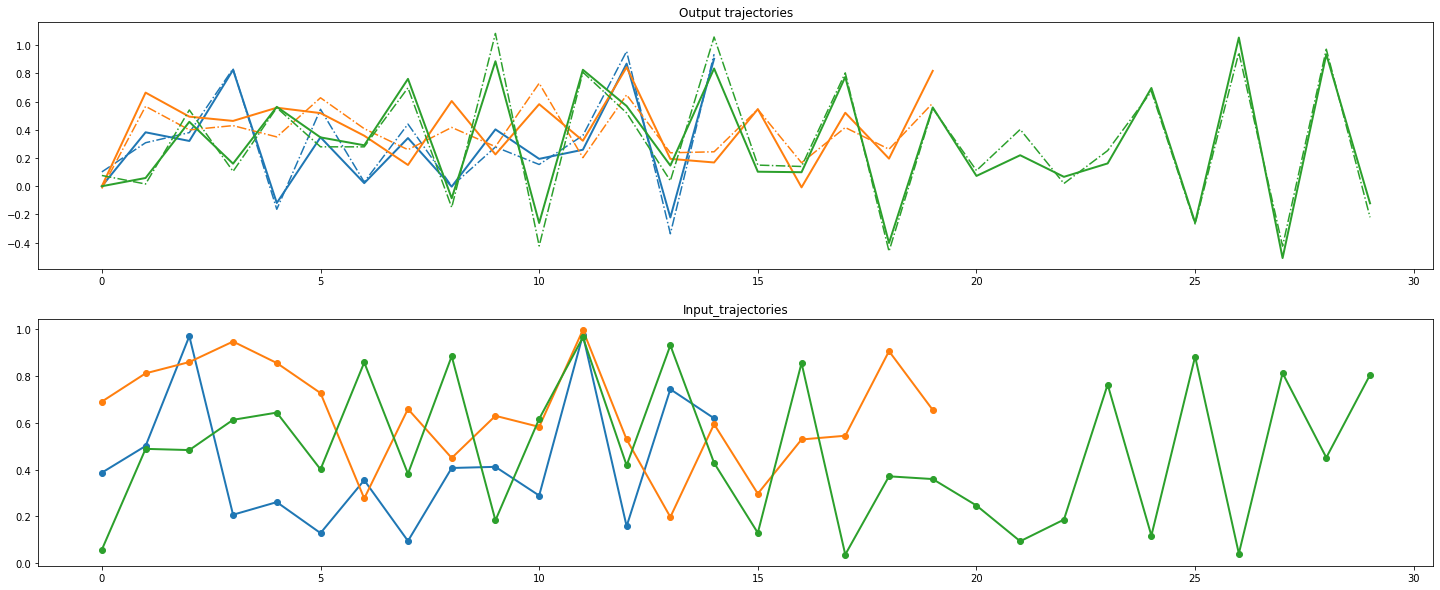

In [5]:
# right hand side
def rhs(x, u, a=-0.5, s=0.1, b=0.5):
    return a * x + s * np.sin(20 * x**2) + b * (np.sin(u) + u)


N_traj = 3
T = [15, 20, 30]
Y = []
Y_noisy = []
U = []
for n_traj, T_traj in enumerate(T):
    y = np.zeros((T_traj, 1))
    u = np.random.rand(T_traj, 1)
    for t in range(T_traj - 1):
        y[t + 1] = rhs(y[t], u[t])
    Y.append(y)
    Y_noisy.append(y + np.random.randn(T_traj, 1) / 10)
    U.append(u)
fig, ax = plt.subplots(2, 1)
for y, y_noisy, u in zip(Y, Y_noisy, U):
    curr_line = ax[0].plot(y, "-", lw=2)
    ax[0].plot(y_noisy, "-.", color=curr_line[0].get_color())
    ax[1].plot(u, "-o", lw=2)
ax[0].set_title("Output trajectories")
ax[1].set_title("Input_trajectories")

### Create and fit `DynamicalSystemEstimator` object
... which has an API very similar to the `FunctionEstimator`

In [6]:
bias_eval = RKHS.linear_const_eval
sine_kernel = RKHS.SinKernel(max_freq=40)

dynest = RKHS.DynamicalSystemEstimator(
    bias_func_eval=bias_eval, kernel_func_eval=sine_kernel.eval
)

dynest.fit(
    Y_noisy[:-1],
    exogenous_inputs=U[:-1],
    data_cost_weight=10,
    rkhs_weight=1,
    bias_weight=0,
    exo_delays=1,
)

### Evaluate with test trajectory
_Simulation_ refers to using only the intial measurement $y[0]$ and the inputs $u[t]$ to predict the entire trajectory, whereas $k$-_step ahead prediction_ uses the true measurements up to $y[t-k]$ to predict $y[t]$.  
The last one of the generated trajectories was not used to fit, it is used for evaluation now.

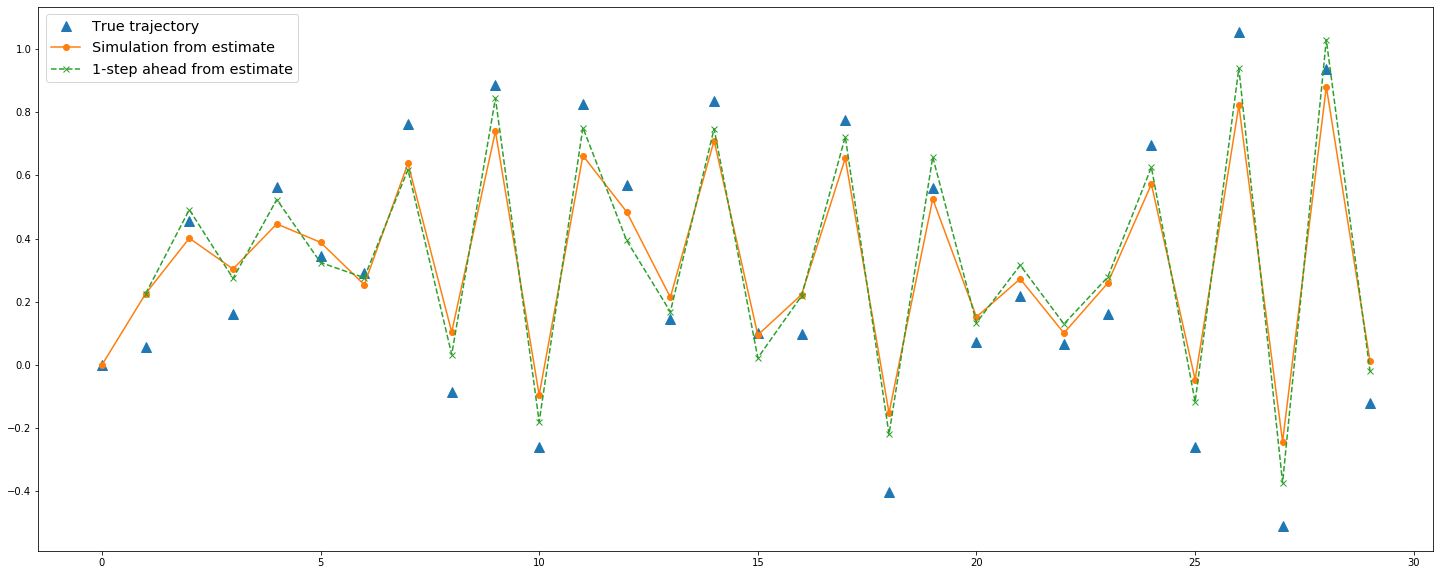

In [7]:
# There's a method for simulation
y_eval_simulation = dynest.simulate(
    np.zeros((1, 1)), traj_len=T[-1], exogenous_inputs=U[-1]
)
# and one for k-step ahead prediction
k_ahead = 1
y_eval_k_step_ahead = dynest.k_step_ahead(Y[-1], exogenous_inputs=U[-1], k=k_ahead)
leading_nans = np.nan + np.zeros((1, len(y_eval_simulation) - len(y_eval_k_step_ahead)))
y_eval_k_step_ahead = np.vstack([leading_nans, y_eval_k_step_ahead])

# Plotting code
plt.plot(Y[-1], "^", label="True trajectory", markersize=10)
plt.plot(y_eval_simulation, "-o", label="Simulation from estimate")
plt.plot(y_eval_k_step_ahead, "--x", label=f"{k_ahead}-step ahead from estimate")
plt.legend(fontsize="x-large")

_Copyright IBM Corp. 2023_

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

       http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.